# Facial Keypoint Detection
## Chandler McCann, Christopher Miller, Rohit Nair, Natarajan Shankar

Loading required packages.

## Troubleshooting tips for why lasagne library is not loaded
first "import theano", then "git clone https://github.com/Lasagne/Lasagne.git", followed by "cd Lasagne" and then "sudo -H python setup.py install"

# W207 Final Project Code

In [1]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

/home/misko/.local/share/jupyter


In [2]:
import sys
sys.executable
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.5/bin/python3')
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages')
#sys.path.append('/home/misko/anaconda3')
#sys.path.append('/home/misko/anaconda3/lib/python3.5/site-packages')

In [3]:
# Telling matplotlib to plot graphs inline
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import time
from matplotlib import cm

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import theano
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import _pickle as pickle

sys.setrecursionlimit(10000)

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is enabled with initial size: 95.0% of memory, cuDNN not available)
/home/misko/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



# STEP 1: UNDERSTAND THE PROBLEM
### 1. The goal is to detect 15 different keypoints on the face
### 2. 7049 training samples are available, some have NaN in attribute fields, needs to be cleaned up
### 3. Once cleaned up data is available, study the cleaned up data to see whether cleanup added value
### 4. Run PCA to narrow down the dimensionality
### 5. With narrowed dimensionality, train and predict using Neural nets 

# STEP 2: LOAD THE DATA AND DO BASIC CLEANUP

Loading train data and getting some information about its structure.

In [4]:
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

def load(test=False, cols=None, logging=True):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    # Just for the visual record, have the data printed out
    print(df.count())  # prints the number of values for each column
 
    # Get all the rows that have some NA fields
    dfna = df[df.isnull().any(axis=1)]

    # For the first level of processing, use only the records that have
    # complete data (no NaN)
    df = df.dropna()  # drop all rows that have missing values in them

    # Stick to 4 decimal points in order to have well formatted output
    # There are 2 dataframes
    #    df - dataframe with complete data
    #    dfna - dataframe with records that have NaN
    df.round(4)
    dfna.round(4)
    
    # Return processed data and the 2 dataframes
    return df, dfna


# Load the data
train_df, train_dfna = load()
test_df, test_dfna = load(test=True)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## Additional Cleanup
### Dealing with rows that have NAs
#### 1. 4909 rows have NAs in some fields. These rows otherwise carry important information and this information in other columns must somehow be used. 
#### 2. 2140 rows have complete information and can used as a training set.
#### 3. The the field averages from the complete set and use the field averages to fill in and complete the set with NaNs
#### 4. This approach will provide a full 7049 rows if data that can be used for building predictive models.

In [5]:
# If true, program attempts to fix images with missing keypoints
include_errors = False

def repair_dataset(train_df=train_df, train_dfna=train_dfna, logging=True): 
    # How many rows have null features exist?
    dfnacheck_before = len(train_dfna[train_dfna.isnull().any(axis=1)])
    if (logging==True):
        print("Rows with NA features before cleanup: %d" % dfnacheck_before)

    # Now compute the average of every column and use the averages to fill in the NaN fields in dfna
    for feature in train_dfna:
        if feature != 'Image':
            mean = train_df[feature].mean() * 1.0
            train_dfna[feature] = train_dfna[feature].fillna(mean)

    # Assert that all null features have been dealt with.
    dfnacheck_after = len(train_dfna[train_dfna.isnull().any(axis=1)])
    assert(dfnacheck_after == 0)
    if (logging==True):
        print("Rows with NA features after cleanup: %d" % dfnacheck_after)

    # Merge the df and dfna dataframes together to create a much larger data set
    #repaired = pd.concat([train_df, train_dfna])
    repaired = train_df.append(train_dfna)

    if (logging==True):
        print("Size of corrected dataset: %d" % len(repaired))
    return repaired

# Finish creating the data
def get_data(df, test=False, col=None, logging=True):
    if logging==True:
        print(df.count())
    
    # Normalize the given data
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48 # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        
    else:
        y = None
    return X, y

if include_errors == True:
    repaired_df = repair_dataset()
    train_data, train_labels = get_data(repaired_df, logging=False)
else:
    train_data, train_labels = get_data(train_df, logging=False)
test_data, test_labels = get_data(test_df,test=True, logging=False)

# Print out data boundaries
print("train_data.shape == {}; train_labels.min == {:.3f}; train_labels.max == {:.3f}".format(
        train_data.shape, train_data.min(), train_data.max()))
print("train_labels.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
        train_labels.shape, train_labels.min(), train_labels.max()))


train_data.shape == (2140, 9216); train_labels.min == 0.000; train_labels.max == 1.000
train_labels.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [6]:
print(test_data.shape)
# test labels do not exist, cannot check for tes_labels.shape

(1783, 9216)


## For data visualization, need a plot routine
### Copy the plot code as published in 
https://www.ischool.berkeley.edu/sites/default/files/projects/14-dailey_jang_oneto_yang_final.pdf

In [7]:
def compare_images(image1, p1, image2, p2): 
    p1 = p1 * 48 + 48
    p2 = p2 * 48 + 48
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1) 
    plt.imshow(np.reshape(image1,(96,96)), cmap = cm.gray) 
    for x, y in np.reshape(p1,(len(p1)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')
    plt.subplot(1,2,2) 
    plt.imshow(np.reshape(image2,(96,96)), cmap = cm.gray) 
    for x, y in np.reshape(p2,(len(p2)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')

# # Keep data consistent.
# np.random.seed(0)
# sample = np.floor(np.random.rand(2, 2) * len(train_data))

# print("Display some sample images with their keypoints:")
# for i in sample:
#     compare_images(train_data[i[0]], train_labels[i[0]], train_data[i[1]], train_labels[i[1]])


## STEP 3 : Set up plotting

Plotting


In [8]:
def graph_results(net):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(1e-4, 1e-2)
    plt.yscale("log")
    plt.show()

# Data Adjustment: Algorithm # 1
### Histogram Stretching
A simple way of image enhancement that improves the contrast in an image by stretching the range of pixel intensity to span the entire range from minimum (0) to maximum (1). Over 8 bits, this algorithm expands the contrast in the image over the entire 0 to 255 range

The reference article is:
http://cs229.stanford.edu/proj2014/Yue%20Wang,Yang%20Song,Facial%20Keypoints%20Detection.pdf
#### Ref: Facial Keypoints Detection, by Yue Wang and Yang Song, Stanford University

In [9]:
def compare_histograms(frame1, frame2):
        fig = plt.figure(figsize=(16,8))
        # the histogram of the data
        fig.add_subplot(1,2,1)
        n, bins, patches = plt.hist(frame1, 20, facecolor='green')
        l = plt.plot(bins, 'r--', linewidth=1)

        plt.xlabel('Pixel value')
        plt.ylabel('Pixel Count')
        plt.title('Pre-Histogram Transformation')
        plt.axis([0, 1, 0, 3000])
        plt.grid(True)

        fig.add_subplot(1,2,2)
        n, bins, patches = plt.hist(frame2, 20, facecolor='green')
        l = plt.plot(bins, 'r--', linewidth=1)

        plt.xlabel('Pixel value')
        plt.ylabel('Pixel Count')
        plt.title('Post-Histogram Transformation')
        plt.axis([0, 1, 0, 3000])
        plt.grid(True)


def stretch_histogram(frame):
    # Save the incoming 
    new_frame = []
    
    # Algorithm is very sensitive to outliers at both ends
    # So, focus on the 5th and 95th percentile points as as proposed by Song et al.
    a = np.percentile(frame, 5)
    b = np.percentile(frame, 95)
    u = 1 # desired_max_pixel_value
    l = 0 # desired_min_pixel_value

    # Algorithm fails to optimize if low and high values are at the extreme
    if a == 0 and b == 1:
        return(frame)
    
    # If frame is all white or all black, skip processing
    if a == 1 or b == 0:
        return(frame)

    for x in range(0, len(frame)):
        if (frame[x] > b):
            new_frame.append(np.float32(1.0))
        elif (frame[x] < a):
            new_frame.append(np.float32(0.0))
        else:
            p_prime = np.float32(((u - l) / (b - a)) * (frame[x] - a) - l)
            new_frame.append(p_prime)
            if (p_prime < 0) | (p_prime > 1):
                pass
                #print(x, p_prime)
    #print(np.array(new_frame))
    return np.array(new_frame).astype(np.float32)

# # Keep data consistent.
# np.random.seed(0)
# sample = np.random.rand(2) * len(train_data)

# for i in sample:
#     before = train_data[i]
#     after = stretch_histogram(train_data[i])

#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, train_labels[i])


# # For python v2
# start = time.time()
# train_stretched = np.array(map(stretch_histogram, train_data))
# print("Finished stretching sample train_data map in %4f seconds" % (time.time() - start))


# For python v3
# Routine to stretch all histograms in training data
def stretch_histogram_all(train_data=train_data):
    train_hist_stretch = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        train_hist_stretch[index] = np.array(stretch_histogram(train_data[index]))
    return np.array(train_hist_stretch)


## Data Adjustment: Algorithm # 2
### Histogram Shifting
A simple way of image enhancement that improves the contrast in an image by shifting the intensity of the pixels to the right. Lighter pixels are darker and darker pixels are enhanced. 
The reference article is: www.tutorialspoint.com

In [10]:
# Load data and shift
def shift_histogram_right(frame, shift=0.3):
    
    new_frame = []
    
    for i in range(0, len(frame)):
        new_value = frame[i] + shift
        if new_value > 1.0:
            new_frame.append(np.float64(1.0))
        else:
            new_frame.append(new_value)
    
    return np.array(new_frame).astype(np.float32)


# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(2) * len(train_data)

# Amount of right shift
r_shift = 0.30


# for i in sample:
#     before = train_data[i]
#     after = shift_histogram_right(train_data[i], shift=r_shift)
#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()

# train_shift_right = np.array(map(shift_histogram_right, train_data))
# print("Finished shifting RIGHT train_data in %4f seconds" % (time.time() - start))

# Load data and shift
def shift_histogram_left(frame, shift=0.3):
    new_frame = []
    
    for i in range(0, len(frame)):
        new_value = frame[i] - shift
        if new_value < 0.0:
            new_frame.append(np.float64(0.0))
        else:
            new_frame.append(new_value)
    
    return np.array(new_frame).astype(np.float32)


# Keep data consistent.
np.random.seed(0)
sample = np.random.rand(2) * len(train_data)

# Amount of left shift
l_shift = 0.2

# for i in sample:
#     before = train_data[i]
#     after = shift_histogram_left(train_data[i], shift=l_shift)
#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, train_labels[i])

# Looks like everything is working well, generate the new set of data to go forward with
start = time.time()


# For python v3
# Routine(s) to shift all histograms in training data
def shift_histogram_right_all(train_data=train_data):
    train_shift_right = np.zeros((len(train_data), train_data.shape[1]))
    for index in range(0, len(train_data)):
        train_shift_right[index] = np.array(shift_histogram_right(train_data[index]))
    return np.array(train_shift_right)

def shift_histogram_left_all(train_data=train_data):
    train_shift_left = np.zeros((len(train_data), train_data.shape[1]))
    for index in range(0, len(train_data)):
        train_shift_left[index] = np.array(shift_histogram_left(train_data[index]))
    return np.array(train_shift_left)


## More augmentation

### Gaussian Blur

Gaussian Blur changes cell values to a weighted average of surrounding cells.  

In [11]:
def gaussian_blur(origin, matrix, blur=1):
    sd = 2
    pi = np.pi
    e = np.e
    cartesian = []
    coords = []
    weights = []
    blurred_pixel = 0.0

    x = origin[0]
    y = origin[1]
    
    for i in range(-blur, blur):
        for j in range(-blur, blur):
            cartesian.append([i, j])
            try:
                if ((x - i) == 0) | ((y - j) == 0):
                    raise IndexError
                coords.append(matrix[x + i][y + j])
            except IndexError:
                coords.append(matrix[x][y])
    weights = []
    for pair in cartesian:
        x = pair[0]
        y = pair[1]
        weight = (1.0 / (2 * pi * sd ** 2)) * (e ** -((x ** 2 + y ** 2) / (2 * sd ** 2))) # 2D Gaussian function
        weights.append(weight)
    averages = [w / sum(weights) for w in weights]
    for i in range(0, len(coords)):
        blurred_pixel += coords[i] * averages[i]

    return blurred_pixel

def apply_blur(img):
    blurred_matrix = []
    matrix = img.reshape(96, 96)
    for row in range(0, len(matrix)):
        for col in range(0, len(matrix[row])):
            origin = [row, col]
            blurred_matrix.append(gaussian_blur(origin, matrix))
    return np.array(blurred_matrix).astype(np.float32)


# np.random.seed(0)

# for i in sample:
#     before = train_data[i]
#     after = apply_blur(train_data[i])
#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, train_labels[i])


# For python v3
# Routine to gaussian shift all the images in the training data
def apply_blur_all(train_data=train_data):
    blur_all = np.zeros((len(train_data), 9216))
    for index in range(0, len(train_data)):
        blur_all[index] = np.array(apply_blur(train_data[index]))
    return np.array(blur_all)


## Critical Pixel Enhancement

In [12]:
# The labels and their indexes
critical_points = ["left_eye_center_x", "left_eye_center_y", 
                       "right_eye_center_x", "right_eye_center_y",
                       "left_eye_inner_corner_x", "left_eye_inner_corner_y", 
                       "left_eye_outer_corner_x", "left_eye_outer_corner_y",
                       "right_eye_inner_corner_x", "right_eye_inner_corner_y",
                        "right_eye_outer_corner_x", "right_eye_outer_corner_y",
                       "left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y",
                       "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y",
                       "right_eyebrow_inner_end_x ", "right_eyebrow_inner_end_y", 
                       "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y",
                       "nose_tip_x", "nose_tip_y",
                        "mouth_left_corner_x", "mouth_left_corner_y",
                       "mouth_right_corner_x", "mouth_right_corner_y", 
                      "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y", 
                       "mouth_center_top_lip_x", "mouth_center_top_lip_y"
                  ]


## CRITICAL PIXEL ENHANCEMENT - 

In [13]:
import copy
import math
# This function sets up the 9 bins for digitizing the data for a frame X
def setup_heatmap(X):
    bins = np.arange(0, 1.0, 0.111) # Set up 9 bins for holding data
    
    # digitize the incoming data into bins
    binplace = np.digitize(X, bins, right=True)
    
    # Flatten for vector processing
    binplace = binplace.flatten()
    
    # return the bins
    return binplace


def computeCentroid(eye_1, eye_2):
    
    #print(eye_1, eye_2)
    center_eye_1 = [0,0]
    center_eye_2 = [0,0]
    
    if len(eye_1) > 0 and len(eye_2) > 0:
        # Put all the eye data together
        # print(len(eye_1), len(eye_2))
        eye_1_x,eye_1_y=list(zip(*eye_1))
        eye_2_x,eye_2_y=list(zip(*eye_2))
    
        # Compute the centroid coordinates. There most likley is a better formula
        center_eye_1=sum(eye_1_x)/len(eye_1), sum(eye_1_y)/len(eye_1)
        center_eye_2=sum(eye_2_x)/len(eye_2), sum(eye_2_y)/len(eye_2)
    
    return center_eye_1, center_eye_2

def PreProcessFrame(data, labels, plot=False):

    X = process_image(data, labels, plot=plot)

    labels = labels * 48 + 48
    # Attach a color with each bin, in this case 9 colors, one for each bin
    # We are not interested in all colors, only the colors that highlight the eyes. 
    # so, make other colors "white" so that they do not show.
    # Determined through trial and error that bins 2 and 3 are the best bins for the eyes
    cmap = colors.ListedColormap(['white', 'white', 'orange', 'red', 'white', 'white', 'white', 'white', 'white'])
    bounds=[0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Create the digitized 9 bins
    binplace = setup_heatmap(X)

    # Flatten for further use into a 9216 array
    X_flattened = X.flatten()
    return binplace, X, X_flattened, labels

def determine_eye_coordinates(eye_indices):
    
    # Two lists are needed to hold the pixels that 
    # represent each eye
    eye_1_pos = []
    eye_2_pos = []

    processed_flag = 0
    # The eyes are usually part of the dark pixels in the images
    # And dark pixels are captured in the lowest 3 digitized bins. Learned through 
    # trial and error by observing the heat maps of multiple images

    # Now extract the two eye sets
    # The eyes fall within rectangles defined by multiple rows and columns
    # Each pixel is represented by a (row * column) number 
    # Start the count from the top left of the photo
    # The two rectangles are through the observation of multiple images
    for item in eye_indices:
        #print("Item is {}".format(item))
        if (item > 2900 and item < 2920) or \
            (item > 2996 and item < 3016) or \
            (item > 3092 and item < 3112) or \
            (item > 3188 and item < 3208) or \
            (item > 3284 and item < 3304) or \
            (item > 3380 and item < 3400) or \
            (item > 3476 and item < 3496) or \
            (item > 3572 and item < 3592) or \
            (item > 3668 and item < 3688) or \
            (item > 3764 and item < 3784) or \
            (item > 3860 and item < 3880):
            
            processed_flag = 1
            #print("Processed eye 1 {}".format(item))
            
            eye_1_pos_y = item//96  # The whole number part is the row or y
            eye_1_pos_x = item%96 # The fractional part is the column or x
        
            #print(eye_1_pos_x, eye_1_pos_y)
            # Add to a list that defines eye number 1
            eye_1_pos.append((eye_1_pos_x, eye_1_pos_y))
        
        # Do exactly the above for the second eye. Only the bounding rectangle is different
        elif (item > 2939 and item < 2959) or \
            (item > 3035 and item < 3055) or \
            (item > 3131 and item < 3151) or \
            (item > 3227 and item < 3247) or \
            (item > 3323 and item < 3343) or \
            (item > 3419 and item < 3439) or \
            (item > 3515 and item < 3535) or \
            (item > 3611 and item < 3631) or \
            (item > 3707 and item < 3727) or \
            (item > 3803 and item < 3823) or \
            (item > 3899 and item < 3919):
            
            processed_flag = 1
            #print("Processed eye 2 {}".format(item))
            
            eye_2_pos_y = item//96
            eye_2_pos_x = item%96
        
            #print(eye_2_pos_x, eye_2_pos_y)
            # List of pixels that define the second eye
            eye_2_pos.append((eye_2_pos_x, eye_2_pos_y))

    if processed_flag == 0:
        eye_1_pos = [(0,0)]
        eye_2_pos = [(0,0)]
        
    # Return the pixel coordinates of the 2 eye clusters
    return (eye_1_pos, eye_2_pos)


def VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging=False):
    # There is a possibility that the first chosen 2 bins do not have any eye pixel
    # Successively add a bin until there are non-zero data points in the eye rectangle
    # This is kludgy stuff - my apologies!
    processed_flag = 0
    if len(eye_1)==0 or len(eye_2)==0:
        if logging==True:
            print("Adding a bin")
        eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3))[0])
        eye_1, eye_2 = determine_eye_coordinates(eye_indices)
        if len(eye_1)==0 or len(eye_2)==0:
            if logging==True:
                print("Adding another bin")
            eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4))[0])
            eye_1, eye_2 = determine_eye_coordinates(eye_indices)
            if len(eye_1)==0 or len(eye_2)==0:
                if logging==True:
                    print("Adding yet another bin ")
                eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4)|(binplace==5))[0])
                eye_1, eye_2 = determine_eye_coordinates(eye_indices)
                if len(eye_1)==0 or len(eye_2)==0:
                    if logging==True:
                        print("Adding the last 4 bins - the last attempt")
                    eye_indices = list(np.where((binplace==1)|(binplace==2)|(binplace==3)|(binplace==4)|\
                                        (binplace==5)|(binplace==6)|(binplace==7)|(binplace==8)|(binplace==9))[0])
                    eye_1, eye_2 = determine_eye_coordinates(eye_indices)
                    if len(eye_1)==0 or len(eye_2)==0:
                        eye_1=[]
                        eye_2=[]
                        if (logging==True):
                            print("Could not find eye pixels")
    return(eye_1, eye_2)

def reduce_and_darken_narrower_area(frame, eye_1, eye_2):

    if len(eye_1) > 6:
        del eye_1[int(2*len(eye_1)/3):] # delete the upper third
    

    if len(eye_1) > 6:
        eye_1 = eye_1[int(len(eye_1)/3):] # Remove the bottom third
    
    if len(eye_2) > 6:
        del eye_2[int(2* len(eye_2)/3):] # delete the upper third
        
    if len(eye_2) > 6:
        eye_2 = eye_2[int(len(eye_2)/3):] # Remove the bottom third

    # Eye1 1: For all remaining eye pixels, darken them by moving left
    for x in eye_1:
        #print("First eye coordinates {}". format(x))
        z = x[0] + x[1] * 96
        
        frame[z] -= 0.3 # Darken the pixel
        if frame[z] < 0:
            frame[z] = 0 # Don't go negative with darkening
    
    # Eye 2: For all remaining eye pixels, darken them by moving left
    for x in eye_2:
        #print("Second eye coordinates {}". format(x))
        z = x[0] + x[1] * 96
        
        frame[z] -= 0.2 # Darken the pixel
        if frame[z] < 0:
            frame[z] = 0 # Don't go negative with darkening
    return frame

def darken_eyes(frame, logging = False):

    #print("New Frame")
    X = np.reshape(frame,(96,96))

    # Create the digitized 9 bins
    binplace = setup_heatmap(X)

    # Flatten for further use into a 9216 array
    X_flattened = X.flatten()
    
    # Start with assumption that 1 and 2 are the bins within which the eye resides
    eye_indices = list(np.where((binplace==1)|(binplace==2))[0])

    #print("darken_eyes: eye indices are {}".format(eye_indices))
    # Given the bins, find the eye coordinates
    eye_1, eye_2 = determine_eye_coordinates(eye_indices)
    #print("darken_eyes: determined eye indices are {}".format(eye_1, eye_2))
    
    if len(eye_1)==0 or len(eye_2)==0:
        frame = shift_histogram_left(frame, shift=0.2)
        if logging==True:
            print("darken_eyes: Left shifted the image")
        eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging=False)
        
    eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging=False)
    
    # compute the centroid of both eyes
    #print(eye_1, eye_2)
    centroid_eye_1, centroid_eye_2 = computeCentroid(eye_1, eye_2)
    #print("Centroid is {} {}".format(centroid_eye_1, centroid_eye_2))
    # be selective about how many spots to darken. Stay close to the centroid
    # Visit at a later time
    
    if logging == True:
        plt.figure(figsize=(8, 4))
        plt.imshow(np.reshape(frame,(96,96)), cmap = cm.gray) 
    
    # Darken just the Centroids
    z1 = centroid_eye_1[0] + 96 * centroid_eye_1[1]
    z2 = centroid_eye_2[0] + 96 * centroid_eye_2[1]
    frame[z1] -= 0.15 # Darken the pixel
    frame[z2] -= 0.15 # Darken the pixel
    
    # Centoid has been darkened
    # Now work on the middle items in the list of eye pixels, ignore the outliers
    #frame = reduce_and_darken_narrower_area(frame, eye_1, eye_2)
    
    return frame

# Routine to loop through and darken all eyes in all images in training data
def darken_eyes_all(images, logging=False):
    for i in range(0, len(images)):
        #print("The image index is {}".format(i))
        images[i] = darken_eyes(images[i])
    return(np.array(images))

# # IGNORE THIS ROUTINE FOR NOW, IT IS NOT USED
# def enhance_critical_points(frame, attributes):

#     # unscale the attribute form its -1, 1 boundaries
#     attributes = attributes * 48 + 48

#     #attribute = attribute[[6,7,10, 11, 20, 21, 22, 23, 24, 25]]
#     attributes = attributes[[0,1]]
#     #print(len(attribute))
#     critical_pixels = [] * len(attributes)
#     #attribute = attribute * 48 + 48
#     for x, y in np.reshape(attributes,(len(attributes)/2, 2)):
#         #print(x,y)
#         critical_pixels.append(int((x*y)))
#         #print("x, y is {}  {} {}".format(x,y, x*y))

#     # Amount by which to increase the area around each critical point
#     shift = 0.5

#     # Loop for every one of 10 critical features
#     #for index in feature_index:
#     count = 0
#     for pixel_value in critical_pixels:
#         z = frame[pixel_value]
#         #print(z)
#         if z-shift >= 0:
#             frame[pixel_value] -= shift
#         else :
#             frame[pixel_value] = 0

#         count += 1

#     # Return the critical point enhanced frame 
#     return np.array(frame).astype(np.float32)

# cpe_dataset = repair_dataset(logging=False)
# X_CPE, y_CPE = get_data(cpe_dataset, logging=False)

# np.random.seed(22)
# sample = np.random.rand(5) * len(X_CPE)


# # Routine to loop through and enhance all eyes in all images
# def enhance_critical_points_all(frame=train_data, attributes=train_labels):
#     train_enhanced_eyes = np.zeros((len(train_data), 9216))
#     for index in range(0, len(train_data)):
#         #train_enhanced_eyes[index] = np.array(enhance_critical_points(train_data[index], attributes[index]))
#         train_enhanced_eyes[index] = np.array(darken_eyes(train_data[index]))
#     return np.array(train_enhanced_eyes)


## IMAGE ROTATION

In [14]:
# Given one frame and coordinates of its labels...
# 
# If "plot" is True, show the red dots on the image and return a 96 by 96 matrix
# If "plot" is False, just return a 96 by 96 matrix
def process_image(image, labels, plot=False): 

    if plot == True:
        labels = labels * 48 + 48
        #plt.figure(figsize=(8, 4))
        #print("process_image I")
        plt.imshow(np.reshape(image,(96,96)), cmap = cm.gray) 
        for x, y in np.reshape(labels,(len(labels)/2, 2)):
            plt.plot(x, y, 'r.')
        plt.axis('off')
        plt.show()
    return np.reshape(image,(96,96))


from math import *

def getAngleBetweenPoints(x_1, y_1, x_2, y_2):
    deltaY = y_2 - y_1
    deltaX = x_2 - x_1
    angle = atan2(deltaY, deltaX) # angle in radians
    
    # convert angle to degrees and return
    return angle * 180/pi


def rotate_point(centerPoint,point,angle):
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , \
                              temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

def rotate_labels(labels, label_count, axis, angle):
    labels_rotated=[]

    for i in range(0, label_count, 2):
        point=[labels[i], labels[i+1]]
        new_x, new_y = rotate_point(axis, point, angle)
        labels_rotated.append((new_x, new_y))
    return labels_rotated

from matplotlib import colors
from skimage import data
from skimage.transform import rotate

# Rotate the image
# "data" here is one image frame
def image_rotate(data=train_data, labels=train_labels, plot=False, \
                                                 logging = False, label_count=30):

    # ensure that the rotation direction is logged
    rotation_direction=1  # anti-clockwise by default
    angle = 0
    
    
    # Preprocess the data 
    binplace, X, X_flattened, labels = PreProcessFrame(data, labels, plot=plot)

    # Start with assumption that 1 and 2 are the bins within which the eye resides
    eye_indices = list(np.where((binplace==1)|(binplace==2))[0])
    
    # Given the bins, find the eye coordinates
    eye_1, eye_2 = determine_eye_coordinates(eye_indices)

    loopIndex = 0
    shift = 0.2
    while len(eye_1) == 0 or len(eye_2) == 0:
        shift_histogram_left(data, shift = shift)
        if logging==True:
            print("{} attempt at fixing via darkening of image".format(loopIndex+1))
        eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2, logging)
        if len(eye_1) > 0 and len(eye_2) > 0:
            break
        else:
            if loopIndex == 1:
                if logging==True:
                    print("Eye recognition error I - Image is too light")
                return labels, X_flattened
        loopIndex +=1
        if loopIndex > 2:
            break
    
    loopIndex = 0
    shift = 0.3
    while len(eye_1) == 0 or len(eye_2) == 0:
        shift_histogram_right(data, shift = shift)
        if logging==True:
            print("{} attempt at fixing via lightening of image".format(loopIndex+1))
        eye_1, eye_2 = VerifyAndFixEyeCoordinates(binplace, eye_1, eye_2)
        if len(eye_1) > 0 and len(eye_2) > 0:
            break
        else:
            if loopIndex == 1:
                if logging==True:
                    print("Eye recognition error II - too dark")
                return labels, X_flattened
        loopIndex +=1
        if loopIndex > 2:
            break
    
    # One last net to catch data where eye cannot be recognized
    # If there is a picture where no pixels appear in the eye rectangle,
    # we have no choice but to give up. I have not seen this happen. 
    if len(eye_1)==0 or len(eye_2)==0:
        if logging==True:
            print("Eye index is zero, sending back original data")
        return labels, X_flattened
    
    # I was not sure how an assignment of X into X_flattened would work, so I decided 
    # to make an explicit copy. I needed a copy because we are going to munge this
    # new frame with rotated pixel values. Start by initializing all pixels to 0
    #Xcopy = X_flattened.copy()
    Xcopy=X_flattened
#     for i in X_flattened:
#         Xcopy[i] = 0
        
    # The visual of having located the eye pixels and overlaying them on the 
    # original image is powerful
    # Plot the eye pixels on top of the original image
    if plot==True and logging==True:
        plt.scatter(*zip(*eye_1))
        plt.scatter(*zip(*eye_2))
    
    if len(eye_indices) != 0:
        for element in eye_indices:
            Xcopy[element] = X_flattened[element]
    else:
        if logging==True:
            print("eye_indices is zero")

    # Reshape for further processing
    Xcopy = np.reshape(Xcopy,(96,96))

    center_eye_1, center_eye_2 = computeCentroid(eye_1, eye_2)

    if logging==True:
        print("The centroid values are {} {}".format(center_eye_1, center_eye_2))

    # compute  the angle with the horizontal
    # using the coordinates of the 2 eyes
    angle = getAngleBetweenPoints(center_eye_1[0], center_eye_1[1], \
                                      center_eye_2[0], center_eye_2[1])

    # Needs skimage imports
    if (center_eye_2[1] < center_eye_1[1]):
        #print("Anti clockwise rotation") because left eye is lower than the right eye, 
        # right eye is axis
        X_rotated = rotate(X, 360 - abs(angle), center = [center_eye_2[0], center_eye_2[1]], \
                                   mode = 'symmetric',\
                                   resize = False, clip = True, preserve_range = True)
        #Rotate the labels
        if logging==True:
            print("C angle of rotation is {} {}".format(angle, radians(angle)))
        rotated_labels = rotate_labels(labels, label_count, [center_eye_2[0], \
                                                        center_eye_2[1]], -angle)
        angle = 360-angle
        rotation_direction=1

    else:
        #print("Anti clockwise rotation"), right eye is lower than the left eye, left eye is axis
        X_rotated = rotate(X, abs(angle), center =[center_eye_1[0], center_eye_1[1]], \
                                   mode='symmetric',\
                                  resize = False, clip = True, preserve_range = True)
    
        #Rotate the labels
        if logging==True:
            print("AC angle of rotation is {} {}".format(angle, radians(angle)))
        rotated_labels = rotate_labels(labels, label_count, [center_eye_1[0], \
                                                             center_eye_1[1]], -angle)
        angle = -angle
        rotation_direction=0
        
    # Not sure why I check but I want  to make sure that we have an array of size 9216
    if X_rotated.flatten().shape[0] != 9216:
        if logging==True:
            print("Something wrong {}".format(X_rotated.flatten().shape[0]))

    # Return the rotated image and its parameters
    return rotated_labels, X_rotated



        
def sample_rotate(train_data=train_data, train_labels=train_labels, sample=100, \
                                              logging=False, label_count=30):
    # ROTATION 
    # The main calls are here
    plot=False
    # Rotate the images
    rotated_labels, rotated_image = image_rotate(data = train_data[sample], \
                        labels = train_labels[sample], plot=plot, logging=logging, \
                                                 label_count=label_count)

    if logging==True:
        # show the original
        plt.imshow(np.reshape(train_data[sample],(96,96)), cmap = cm.gray)
        plt.show()

        # Now show the rotated image
        if rotated_image is not None:
            labels = np.array((np.array(rotated_labels) -48)/48)
            labels = labels.flatten()
            process_image(image = np.array(rotated_image), \
                          labels = labels, plot=True)

    return np.array(rotated_image).flatten(), np.array(rotated_labels).flatten()
            
def sample_rotate_all(train_data=train_data, train_labels=train_labels, label_count=30):

    samples = len(train_data)
    logging = False
    plot = True
    # allocate storage for results
    print("sample_rotate all")
    train_rotated = np.zeros((len(train_data), train_data.shape[1]))
    labels_rotated = np.zeros((len(train_data), train_labels.shape[1]))
    
    # For the training samples
    for sample in range(0, samples):
            train_rotated[sample], labels_rotated[sample] = \
                        sample_rotate(train_data=train_data, train_labels=train_labels,\
                                        sample=sample, logging=False, label_count=label_count)
    print(train_rotated.shape, labels_rotated.shape)
    return train_rotated, labels_rotated
        


In [15]:
# #sample_rotate()
# print("Started rotating all")
# junk1, junk2 = sample_rotate_all()
# print("End of rotating all")


# np.random.seed(0)
# samples = np.floor(np.random.rand(5) * len(train_data))
# for sample in samples:
#     plt.imshow(np.reshape(junk1[sample].flatten(),(96,96)), cmap = cm.gray)
#     plt.show()
# #     labels = np.array((np.array(junk2[sample]) -48)/48)
# #     labels = labels.flatten()
# #     process_image(image = np.array(junk1[sample]), \
# #                           labels = labels, plot=True)

## IMAGE REFLECTION

In [16]:
def reflect_all_by_y_axis (train_data=train_data, train_labels=train_labels,\
                                       labels=False,label_count=30,logging=False):

    train_data_y_reflection = np.zeros((len(train_data), train_data.shape[1]))
    
    if labels==True:
        #train_labels_y_reflection = train_labels.copy()
        train_labels_y_reflection = train_labels
        train_labels_y_reflection = train_labels_y_reflection*48 + 48
    
    for i in range(0,len(train_data)):
        # For debugging only. 
        if logging==True and i==300 and labels==True:
            
            plt.figure(figsize=(8, 4))
            plt.imshow(np.reshape(train_data[i],(96,96)), cmap = cm.gray)
            
            #print(train_labels[200])
            for x, y in np.reshape(train_labels_y_reflection[i], \
                                       (len(train_labels_y_reflection[i])/2, 2)):
                plt.plot(x, y, 'r.')
                plt.title("Reflection around the Y axis: Original frame")
                plt.ylim([96,0])
                plt.xlim([0,96])

        # Make a copy because we will be manipualting the data
        #train_data_temp = list(train_data[i].copy())
        train_data_temp = list(train_data[i])
        
        # we need to loop 96 times (0 to 95), one for each line of pixels
        N=0
        while N <= 96*95:
            
            # Read the line of pixels and reverse it
            train_data_temp[N:N+96] = train_data_temp[N:N+96][::-1]
            
            # go to the next line
            N += 96
        
        # Picture has been reflected. Save it and work on labels next
        train_data_y_reflection[i] = train_data_temp
        
        # Now, reflect the labels, if labels = True
        # To convert the labels, there are 30 labels, do reflection in pairs, hence step by 2
        # y coordinate does not change, only the x coordinate changes.
        # Loop through and stop at 29 because we only have 30 labels
        if labels==True:
            # use a temporary variable to hold the labels data
            labels_tmp = list(train_labels_y_reflection[i])
            
            if label_count==30:
                #flip_indices = [(0, 2), (1, 3),(4, 8), (5, 9), (6, 10), (7, 11),(12, 16), (13, 17),\
                #               (14, 18), (15, 19),(22, 24), (23, 25),]
                labels_tmp[0], labels_tmp[2] = 96-labels_tmp[2], 96-labels_tmp[0]
                labels_tmp[1], labels_tmp[3] = labels_tmp[3], labels_tmp[1]
                labels_tmp[4], labels_tmp[8] = 96-labels_tmp[8], 96-labels_tmp[4]
                labels_tmp[5], labels_tmp[9] = labels_tmp[9], labels_tmp[5]
                labels_tmp[6], labels_tmp[10] = 96-labels_tmp[10], 96-labels_tmp[6]
                labels_tmp[7], labels_tmp[11] = labels_tmp[11], labels_tmp[7]
                labels_tmp[12], labels_tmp[16] = 96-labels_tmp[16], 96-labels_tmp[12]
                labels_tmp[13], labels_tmp[17] = labels_tmp[17], labels_tmp[13]
                labels_tmp[14], labels_tmp[18] = 96-labels_tmp[18], 96-labels_tmp[14]
                labels_tmp[15], labels_tmp[19] = labels_tmp[19], labels_tmp[15]
                labels_tmp[22], labels_tmp[24] = 96-labels_tmp[24], 96-labels_tmp[22]
                labels_tmp[23], labels_tmp[25] = labels_tmp[25], labels_tmp[23]

                # Nose tip 
                labels_tmp[20], labels_tmp[21] = 96-labels_tmp[20], labels_tmp[21]

                # Mouth bottom
                labels_tmp[26], labels_tmp[27] = 96-labels_tmp[26], labels_tmp[27]

                # Mouth top
                labels_tmp[28], labels_tmp[29] = 96-labels_tmp[28], labels_tmp[29]
            elif label_count==8:
                labels_tmp[0], labels_tmp[2] = 96-labels_tmp[2], 96-labels_tmp[0]
                labels_tmp[1], labels_tmp[3] = labels_tmp[3], labels_tmp[1]
                labels_tmp[4], labels_tmp[5] = 96-labels_tmp[4], labels_tmp[5]
                labels_tmp[6], labels_tmp[7] = 96-labels_tmp[6], labels_tmp[7]
            
            # for every picture/frame, save all the y coordinate changes
            train_labels_y_reflection[i] = np.array(labels_tmp)


        # For debugging only. 
        if labels==True and logging==True and i==300:
            plt.figure(figsize=(8, 4))
            plt.imshow(np.reshape(train_data_y_reflection[i],(96,96)), cmap = cm.gray)
            
            for x, y in np.reshape(train_labels_y_reflection[i], (len(train_labels_y_reflection[i])/2, 2)):
                plt.plot(x, y, 'b.')
                plt.title("Reflection around  the Y axis: Reflected frame")
                plt.ylim([96,0])
                plt.xlim([0,96])

    # return the reflected frames
    return train_data_y_reflection, train_labels_y_reflection


## Reflect the data across the y axis to generate additional training data

In [ ]:
print("Reflect frames around y axis - START")
reflected_data_yaxis, reflected_labels_yaxis = reflect_all_by_y_axis(labels=True, label_count=30, logging=True)

# np.random.seed(0)
# sample = np.random.rand(5) * len(train_data)
# #sample=[200]
# for i in sample:
#     before = train_data[i]
#     after = reflected_data_yaxis[i]
#     #print(after)
#     #compare_histograms(before, after)
#     compare_images(before, train_labels[i], after, (reflected_labels_yaxis[i]-48)/48)
    
    
print("Reflect frames around y axis - END")

## Training Data Augmentation

In [ ]:
# First get the y axis reflection
reflected_labels_yaxis = (reflected_labels_yaxis -48)/48
augmented_data_reflect_y=np.concatenate((train_data, reflected_data_yaxis), axis=0)
augmented_labels_reflect_y=np.concatenate((train_labels, reflected_labels_yaxis), axis=0)

# SET THE augmented_data and augment_labels values here. 
# augmented_data_1=augmented_data_reflect_y.copy()
# augmented_labels_1=augmented_labels_reflect_y.copy()
augmented_data_1=augmented_data_reflect_y
augmented_labels_1=augmented_labels_reflect_y


# Now rotate the data to generate the 3rd block of train data
rotated_data_tmp, rotated_labels_tmp = \
                sample_rotate_all(train_data=augmented_data_1, train_labels=augmented_labels_1, label_count=30)

augmented_data = np.vstack((augmented_data_1, rotated_data_tmp))
#print(augmented_data.shape)

# Normalize the labels
rotated_labels_tmp = (rotated_labels_tmp - 48)/48

# Create the augmented labels matrix
augmented_labels = np.vstack((augmented_labels_1, rotated_labels_tmp))

print(augmented_data.shape)
print(augmented_labels.shape)

In [ ]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)


In [ ]:
#in order to change the learning rates and momemtum, we need to make it a shared variable in theano.
#http://lasagne.readthedocs.io/en/latest/user/layers.html

def float32(var):
    return np.cast['float32'](var)

#This adjust variable call was modified from Danile Nouri's tutorial.
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            #create evenly spaced values based on the starting and stopping values, divided evenly by the num of epochs
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)
        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)


## FEATURE ENGINEERING -AUGMENTED DATA - BASE

### Stretching, Shifting, Blur

In [ ]:
#print(train_data)
from datetime import datetime
print(str(datetime.now()))
print("Starting the generation of composite data")
transformed_data_1 = stretch_histogram_all(augmented_data)
#transformed_data = stretch_histogram_all(train_data)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished stretching. Starting left shift")
print(str(datetime.now()))
transformed_data_2 = shift_histogram_left_all(transformed_data_1)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished shifting. Starting blur")
print(str(datetime.now()))
transformed_data_3 = apply_blur_all(transformed_data_2)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished Blur")
print(str(datetime.now()))

### Darkening

In [ ]:
print(str(datetime.now()))
print("Start darkening eyes")
transformed_data_4 = darken_eyes_all(images=transformed_data_3)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished darkening eyes")
print(transformed_data_4.shape)
print(augmented_labels.shape)

### Create transformed data for feeding into CNET5

In [ ]:
transformed_data_2d = transformed_data_4.reshape(len(transformed_data_4), 1, 96, 96)

In [ ]:
print(transformed_data_2d .shape)
print(transformed_data_4.shape)
print(augmented_labels.shape)

## CNET3 Model

In [ ]:
cnet3_8 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
    hidden5_num_units=500, hidden6_num_units=500, hidden7_num_units=500,
    output_num_units=8, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=2000,
    verbose=1,
    )


In [ ]:
cnet3_30 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
    hidden5_num_units=500, hidden6_num_units=500, hidden7_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=1000,
    verbose=1,
    )

## CNET5 MODEL

In [ ]:
cnet5_30 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(np.float32(0.03)),
    update_momentum=theano.shared(np.float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=1000,
    verbose=1,
    )

In [ ]:
cnet5_8 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=8, output_nonlinearity=None,

    update_learning_rate=theano.shared(np.float32(0.03)),
    update_momentum=theano.shared(np.float32(0.9)),

    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    regression=True,
    max_epochs=1000,
    verbose=1,
    )

### Run the CNET5 Model - Using Original Data

In [ ]:
cnet5.fit(transformed_data_2d.astype(np.float32), augmented_labels.astype(np.float32))

graph_results(cnet5)

with open('cnet5_enhanced_12312016_v3.pickle', 'wb') as f:
    pickle.dump(cnet5, f, -1)
pickle.dump(cnet5, open("cnet5_enhanced_12312016_v2.pickle", 'wb'), protocol=2)

## Keypoints detection in test data

In [ ]:
# Transforming test dataset by applying stretch/shift histogram
# and gaussian blur.
test_transformed= np.array(map(stretch_histogram, test_data))
test_transformed= np.array(map(shift_histogram, test_transformed))
test_transformed= np.array(map(apply_blur, test_transformed))

In [ ]:
test_transformed=augmented_data.astype(np.float32)
from random import randint

test_data_2d = test_transformed.reshape(len(test_transformed), 1, 96, 96)
test_pred = cnet5.predict(test_data_2d) 

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(test_data))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_data[test_idx], test_pred[test_idx], ax)

plt.show()

# FUTURE

### Future: Median Angle Minimization (MAM) Transformation

Centering of a given face with respect to face inherent features is something that our team will study next. By overlaying two independently swiveling orientation triangles on the face and by using medians as the features and by using a transformation to reduce the angle betwen the medians to 0, we hope to better center the face so that prediction algorithmns have a higher degree of accuracy. Figue below captures the basic scheme of Centroids and inter-centoid Angle Measurement

<img src="MAX.png",width=500,height=500>

### Future: Critical Pixel Enhancement (CPE) Transformation + MAM Transformation

A combination of face centering, along with pixel enhancement, at the 6 vertices of the 2 critical orientation 
triangles is also in the future. By enhancing pixel intensity in 5% delta (pixel radius) circles, we hope to highlight
the vertices and hence facilitate better centering and recognition. 

<img src="PET.png",width=500,height=500>

# KAGGLE  DATA: SPLIT DATA SET

In [17]:
FTRAIN = '../data/training.csv'
FTEST = '../data/test.csv'
FLOOKUP ='../data/IdLookupTable.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
#     df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
#         X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

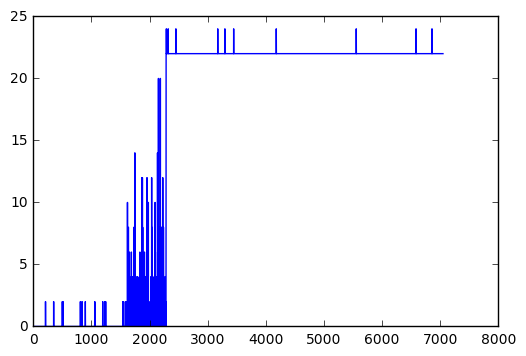

In [18]:
y_count_na = np.sum(np.isnan(y),1)
plt.plot(y_count_na)

In [19]:
idx_ds_2 = y_count_na.tolist().index(22)

img_ds_30 = X[:idx_ds_2]
img_ds_8 = X[idx_ds_2:]

train_ds_30 = y[:idx_ds_2]
train_ds_8 = y[idx_ds_2:]

print(img_ds_30.shape, img_ds_8.shape)
print(train_ds_30.shape, train_ds_8.shape)

(2284, 9216) (4765, 9216)
(2284, 30) (4765, 30)


In [20]:
keypoints = ['left_eye_center_x','left_eye_center_y','right_eye_center_x','right_eye_center_y','left_eye_inner_corner_x', \
             'left_eye_inner_corner_y','left_eye_outer_corner_x','left_eye_outer_corner_y','right_eye_inner_corner_x', \
             'right_eye_inner_corner_y','right_eye_outer_corner_x','right_eye_outer_corner_y','left_eyebrow_inner_end_x', \
             'left_eyebrow_inner_end_y','left_eyebrow_outer_end_x','left_eyebrow_outer_end_y','right_eyebrow_inner_end_x', \
             'right_eyebrow_inner_end_y','right_eyebrow_outer_end_x','right_eyebrow_outer_end_y','nose_tip_x','nose_tip_y', \
             'mouth_left_corner_x','mouth_left_corner_y','mouth_right_corner_x','mouth_right_corner_y', \
             'mouth_center_top_lip_x','mouth_center_top_lip_y','mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']

keypoints_ds_8 = [0,1,2,3,20,21,28,29]


train_ds_8_sub = train_ds_8[:,keypoints_ds_8]
print(train_ds_8_sub.shape)

(4765, 8)


In [21]:
print(train_ds_8[0])
print(train_ds_8_sub[0])
print(train_ds_8_sub[0]*48 + 48)

[ 0.01802703 -0.08503297 -0.5014919  -0.14667109         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.35179999  0.37725243         nan         nan
         nan         nan         nan         nan -0.36500812  0.56656945]
[ 0.01802703 -0.08503297 -0.5014919  -0.14667109 -0.35179999  0.37725243
 -0.36500812  0.56656945]
[ 48.86529541  43.91841888  23.9283886   40.95978928  31.11359978
  66.10811615  30.47961044  75.19533539]


(4755, 9216) (2140, 9216)
(4755, 8) (2140, 30)


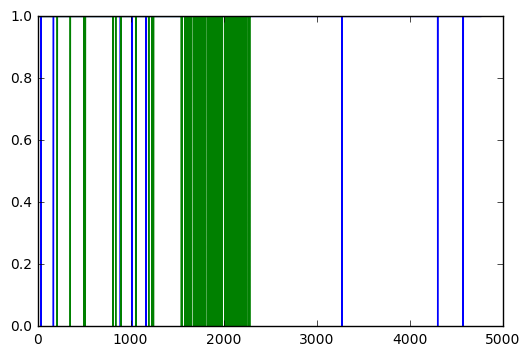

In [22]:
train_8_nona_idx = np.sum(np.isnan(train_ds_8_sub),1) == 0
train_30_nona_idx = np.sum(np.isnan(train_ds_30),1) == 0

img_8_nona = img_ds_8[train_8_nona_idx]
img_30_nona = img_ds_30[train_30_nona_idx]

train_8_nona = train_ds_8_sub[train_8_nona_idx]
train_30_nona = train_ds_30[train_30_nona_idx]

print(img_8_nona.shape, img_30_nona.shape)
print(train_8_nona.shape, train_30_nona.shape)

plt.plot(train_8_nona_idx)
plt.plot(train_30_nona_idx)

In [ ]:
# print(train_8_nona[0])
# print(img_8_nona)
image=0
plt.figure(figsize=(8, 4))
plt.imshow(np.reshape(img_8_nona[image],(96,96)), cmap = cm.gray)
    
print(train_8_nona[image] *48 + 48)
#print(train_labels[200])
for x, y in np.reshape((train_8_nona[image]  * 48) +48, (len(train_8_nona[image])/2, 2)):
    plt.plot(x, y, 'r.')
    plt.title("Reflection around the Y axis: Original frame")
    plt.ylim([96,0])
    plt.xlim([0,96])

In [23]:
def float32(var):
    return np.cast['float32'](var)


#This adjust variable call was modified from Danile Nouri's tutorial.
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            #create evenly spaced values based on the starting and stopping values, divided evenly by the num of epochs
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)
        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

def graph_results(net):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(1e-4, 1e-2)
    plt.yscale("log")
    plt.show()

In [24]:
net_8_d = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
    dropout4_p=0.4,  # !
    hidden5_num_units=500,
    hidden6_num_units=500,
    hidden7_num_units=500,
    output_num_units=8, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
#     batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=2000,
    verbose=1,
    )

## Manipulate the images that have only 8 attributes

Reflect frames around y axis - START
(4755, 9216)
(4755, 8)
(9510, 9216)
(9510, 8)
sample_rotate all
(9510, 9216) (9510, 8)
(19020, 9216)
(19020, 8)


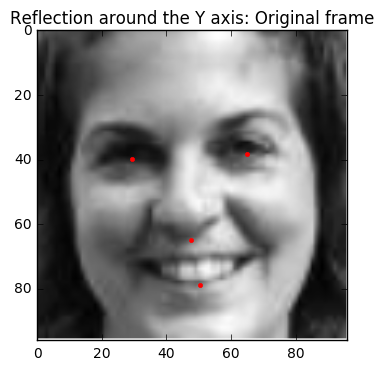

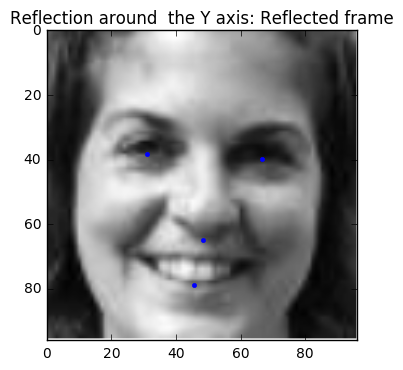

In [25]:
print("Reflect frames around y axis - START")
reflected_data_8, reflected_labels_8 = \
        reflect_all_by_y_axis(train_data=img_8_nona, train_labels=train_8_nona, \
                              labels=True, label_count=8, logging=True)

print(reflected_data_8.shape)
print(reflected_labels_8.shape)

# First get the y axis reflection and append it to train_data
reflected_labels_8=(reflected_labels_8 - 48)/48
augmented_data_8=np.concatenate((img_8_nona, reflected_data_8), axis=0)
augmented_labels_8=np.concatenate((train_8_nona, reflected_labels_8), axis=0)

print(augmented_data_8.shape)
print(augmented_labels_8.shape)

# Now rotate the data to generate the 3rd block of train data
rotated_data_tmp, rotated_labels_tmp = \
                sample_rotate_all(train_data=augmented_data_8, train_labels=augmented_labels_8, label_count=8)

augmented_data_final_8 = np.vstack((augmented_data_8, rotated_data_tmp))
rotated_labels_tmp = (rotated_labels_tmp - 48)/48
augmented_labels_final_8 = np.vstack((augmented_labels_8, rotated_labels_tmp))

print(augmented_data_final_8.shape)
print(augmented_labels_final_8.shape)

In [26]:
#print(train_data)
from datetime import datetime
print(str(datetime.now()))
print("Starting the generation of composite data")
transformed_data_1_8 = stretch_histogram_all(augmented_data_final_8)
#transformed_data = stretch_histogram_all(train_data)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished stretching. Starting left shift")
print(str(datetime.now()))
transformed_data_2_8 = shift_histogram_left_all(transformed_data_1_8)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished shifting")


2017-01-03 22:59:30.280501
Starting the generation of composite data
Finished stretching. Starting left shift
2017-01-03 23:23:48.887954
Finished shifting


In [ ]:
def compute_image_center(train_data=train_data):
    
    image_row_weight = np.zeros(train_data.shape[1]/96)
    image_weight = np.zeros(train_data.shape[0])
    for y in range(0, train_data.shape[0])
        for x in range(0,train_data.shape[1], 96):
            image_row_weight[x] = [sum(train_data[x:x+96,])]
        image_weight[y] = [sum(image_row_weight[0:96])

In [27]:
print("Starting Blur")
print(str(datetime.now()))
transformed_data_3_8 = apply_blur_all(transformed_data_2_8)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished Blur")
print(str(datetime.now()))

Starting Blur
2017-01-03 23:25:15.364969
Finished Blur
2017-01-04 00:25:56.201056


In [28]:
print(str(datetime.now()))
print("Start darkening eyes")
transformed_data_8 = darken_eyes_all(images=transformed_data_3_8)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished darkening eyes")
print(transformed_data_8.shape)
print(augmented_labels_8.shape)

2017-01-04 00:25:56.207668
Start darkening eyes
Finished darkening eyes
(19020, 9216)
(9510, 8)


In [29]:
print(augmented_labels_final_8.shape)
print(augmented_data_final_8.shape)

(19020, 8)
(19020, 9216)


In [ ]:
print(augmented_labels_final_8)

[[ 0.01802703 -0.08503297 -0.5014919  ...,  0.37725243 -0.36500812
   0.56656945]
 [ 0.38614133 -0.20400266 -0.369544   ...,  0.37176001 -0.03668267
   0.67763197]
 [ 0.37761724 -0.23716275 -0.34869516 ...,  0.31621724  0.08017586
   0.59982413]
 ..., 
 [ 0.34586371 -0.23434975 -0.38620218 ...,  0.37424739  0.04292549
   0.59435765]
 [ 0.36368148 -0.15057627 -0.47843917 ...,  0.39010398 -0.0430247
   0.65805086]
 [ 0.35469803 -0.19606867 -0.38975126 ...,  0.51005323  0.06890758
   0.71229211]]


In [ ]:
# np.random.seed(0)
# samples = np.floor(np.random.rand(5) * len(reflected_data_8))
# for sample in samples:
#     plt.imshow(np.reshape(reflected_data_8[sample].flatten(),(96,96)), cmap = cm.gray)
#     plt.show()

In [ ]:
augmented_data_final_8 = transformed_data_8

augmented_data_final_8_2d = augmented_data_final_8.reshape(len(augmented_data_final_8), 1, 96, 96)
net_8_d.fit(augmented_data_final_8_2d.astype(np.float32), augmented_labels_final_8.astype(np.float32))

# Neural Network with 13478308 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  conv4     256x10x10
 11  pool4     256x10x10
 12  dropout4  256x10x10
 13  hidden5   500
 14  hidden6   500
 15  hidden7   500
 16  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.00994     0.00958    1.03736  35.05s
      2     0.00682     0.00804    0.84864  35.17s
      3     0.00675     0.00754    0.89594  35.29s
      4     0.00672     0.00734    0.91543  35.33s
      5     0.00669     0.00718    0.93111  35.35s
      6     0.00667     0.00709    0.94147  35.36s
      7     0.00665     0.00703    0.94607  35.37s
      8     0.00663     0.00697 

In [ ]:
augmented_data_final_8_2d

## Now work with images that have 30 attributes

In [ ]:
net_30_d = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('conv4', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('hidden6', layers.DenseLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    conv4_num_filters=256, conv4_filter_size=(2, 2), pool4_pool_size=(1, 1),
    dropout4_p=0.4,  # !
    hidden5_num_units=500,
    hidden6_num_units=500,
    hidden7_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
#     batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=2000,
    verbose=1,
    )

## Manipulate the images that have 30 attributes

In [ ]:
print("Reflect frames around y axis - START")
reflected_data_30, reflected_labels_30 = \
        reflect_all_by_y_axis(train_data=img_30_nona, train_labels=train_30_nona, \
                              labels=True, label_count=30, logging=True)

print(reflected_data_30.shape)
print(reflected_labels_30.shape)

# First get the y axis reflection and append it to train_data
reflected_labels_30=(reflected_labels_30 - 48)/48
augmented_data_30=np.concatenate((img_30_nona, reflected_data_30), axis=0)
augmented_labels_30=np.concatenate((train_30_nona, reflected_labels_30), axis=0)

print(augmented_data_30.shape)
print(augmented_labels_30.shape)

# Now rotate the data to generate the 3rd block of train data
rotated_data_tmp, rotated_labels_tmp = \
                sample_rotate_all(train_data=augmented_data_30, train_labels=augmented_labels_30, label_count=30)

augmented_data_final_30 = np.vstack((augmented_data_30, rotated_data_tmp))
rotated_labels_tmp = (rotated_labels_tmp - 48)/48
augmented_labels_final_30 = np.vstack((augmented_labels_30, rotated_labels_tmp))

print(augmented_data_final_30.shape)
print(augmented_labels_final_30.shape)

In [ ]:
#print(train_data)
from datetime import datetime
print(str(datetime.now()))
print("Starting the generation of composite data")
transformed_data_1_30 = stretch_histogram_all(augmented_data_final_30)
#transformed_data = stretch_histogram_all(train_data)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished stretching. Starting left shift")
print(str(datetime.now()))
transformed_data_2_30 = shift_histogram_left_all(transformed_data_1_30)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished shifting")


In [ ]:
print("Starting Blur")
print(str(datetime.now()))
transformed_data_3_30 = apply_blur_all(transformed_data_2_30)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished Blur")
print(str(datetime.now()))

In [ ]:
print(str(datetime.now()))
print("Start darkening eyes")
transformed_data_30 = darken_eyes_all(images=transformed_data_3_30)
# print(transformed_data.shape)
# print(transformed_data)
print("Finished darkening eyes")
print(transformed_data_30.shape)
print(augmented_labels_final_30.shape)

In [ ]:
augmented_data_final_30 = transformed_data_30

augmented_data_final_30_2d = augmented_data_final_30.reshape(len(augmented_data_final_30), 1, 96, 96)
net_30_d.fit(augmented_data_final_30_2d.astype(np.float32), augmented_labels_final_30.astype(np.float32))

In [ ]:
graph_results(cnet3_30)

with open('cnet3_30_shankar.pickle', 'wb') as f:
    pickle.dump(cnet3_30.pickle, f, -1)

In [ ]:
FLOOKUP = '../data/IdLookupTable.csv'
submissionImages = read_csv(os.path.expanduser(FLOOKUP))
subKeypoints = submissionImages.groupby(['ImageId']).size()
idx_sub_ds_8 = subKeypoints.tolist().index(8)
print (idx_sub_ds_8)
plt.plot(subKeypoints)

In [ ]:
print(submissionImages[:5])
print(submissionImages[submissionImages['ImageId'] == 592])

In [ ]:
# Prep test data
test_img, foo = load(test=True) 
test_img_30 = test_img[:idx_sub_ds_8]
test_img_8 = test_img[idx_sub_ds_8:]

print(test_img_30.shape, test_img_8.shape)

test_img_30_2d = test_img_30.reshape(len(test_img_30), 1, 96, 96)
test_img_8_2d = test_img_8.reshape(len(test_img_8), 1, 96, 96)

print(test_img_30_2d.shape, test_img_8_2d.shape)

In [ ]:
# Predictions
test_pred_30 = cnet3_30.predict(test_img_30_2d)
** test_pred_8 = cnet3_8.predict(test_img_8_2d)

print(test_pred_30.shape, test_pred_8.shape)

In [ ]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [ ]:
from random import randint

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(test_pred_30))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_img_30[test_idx], test_pred_30[test_idx], ax)
    
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    test_idx = randint(0, len(test_pred_8))
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(test_img_8[test_idx], test_pred_8[test_idx], ax)
    
plt.show()

In [ ]:
test_pred_30_fmt = test_pred_30 * 48 + 48
test_pred_8_fmt = test_pred_8 * 48 + 48

# Generating submissions
arr = [['RowId','ImageId','FeatureName','Location']]
rowIdx = 0

# Parsing first dataset
for i in range(0, test_pred_30.shape[0]):
    for j in range(0, 30):
        rowIdx += 1
        arr.append([rowIdx, i + 1, keypoints[j], test_pred_30_fmt[i,j]])
        
# Parsing second dataset
for i in range(0, test_pred_8.shape[0]):
    for idx, j in enumerate(keypoints_ds_8):
        rowIdx += 1
        # Note ImageId starts from 592 for ds 2
        arr.append([rowIdx, 591 + i + 1, keypoints[j], test_pred_8_fmt[i,idx]])

In [ ]:
print(len(arr), len(arr[0]))
print(submissionImages[:5])
print(arr[:5])
print(submissionImages[-5:])
print(arr[-5:])
print(pd.DataFrame(arr[1:], columns=arr[0])[:5])

In [ ]:
arr_df = pd.DataFrame(arr[1:], columns=arr[0])
submission = pd.merge(left = submissionImages, right=arr_df, how="left", \
                      left_on=["ImageId","FeatureName"], right_on=["ImageId","FeatureName"]) 
print(submission[:5])
print(submission[-5:])

In [ ]:
submissionSub = submission[[0,5]]
submissionSub.columns = ['RowId', 'Location']
submissionSub.to_csv('keypoint_submission_v_shankar_0.2.csv', index=False)

In [ ]:
submissionSub